# Comparison of methods for solving Least Squares Problem


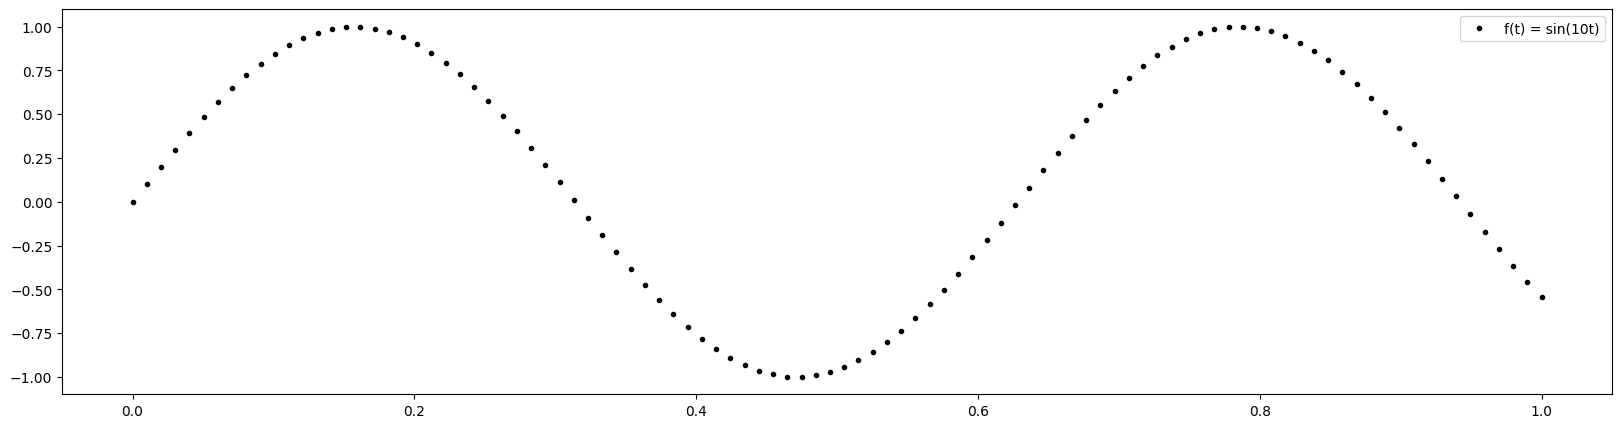

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from copy import deepcopy

import warnings
warnings.filterwarnings('ignore')


%matplotlib inline

t = np.linspace(0,1,100)
f = np.sin(10*t)

def MGS(A : np.array) -> Tuple[np.array, np.array]:
    """
    Returns Q, R for matrix A.
    """
    m,n = A.shape
    Q = np.zeros((m,n))
    R = np.zeros((n,n))
    V = np.zeros((m,n))

    for i in range(n):
        V[:,i] = deepcopy(A[:,i])
    for i in range(n):
        R[i,i] = np.linalg.norm(V[:,i],2)
        Q[:,i] = V[:,i]/R[i,i]

        for j in range(i+1,n):
            R[i,j] = np.dot(Q[:,i],V[:,j])
            V[:,j] = V[:,j] - R[i,j]*Q[:,i]

    return Q, R


def Householder(A: np.array, b: np.array) -> Tuple[np.array, np.array]:
    """
    Takes in A and b to return Qtb and R using Householder Triangularization (Reduced).
    """
    m,n = A.shape
    R = deepcopy(A)
    f = deepcopy(b)
    Q = np.eye(m)
    for k in range(n):
        x = deepcopy(R[k:, k])
        e_1 = np.zeros_like(x); e_1[0] = 1
        v_k = np.sign(x[0])* np.linalg.norm(x,2) * e_1 + x
        v_k = np.reshape(v_k, (m-k,1))
        v_k = v_k / np.linalg.norm(v_k,2)
        
        R[k:, k:] = R[k:, k:] -  2 * v_k @ v_k.T @ R[k:, k:]
        f[k:] = f[k:] - 2 * v_k * (v_k.T @ f[k:])
        Q[:, k:] -= 2 * np.outer(np.dot(Q[:, k:], v_k), v_k)

     # Trim Q to be reduced size (m x n)
    Q_reduced = Q[:, :n]
    
    # Calculate Q^T b (using the reduced Q)
    Qtb = np.dot(Q_reduced.T, b)
    
    # Return reduced Q^T b and upper triangular R
    return Qtb, R[:n, :]

def back_substitution(U: np.ndarray, b: np.ndarray) -> np.ndarray:
    """
    Perform back substitution to solve the equation Ux = b,
    where U is an upper triangular matrix.
    """
    n = U.shape[0]  # Number of equations
    x = np.zeros(n)  # Initialize the solution vector

    for i in range(n - 1, -1, -1):
        if U[i, i] == 0:
            raise ValueError("Matrix U is singular or nearly singular.")
        x[i] = (b[i] - np.dot(U[i, i + 1:], x[i + 1:])) / U[i, i]
    return x

t =  np.linspace(0,1,100)

f = np.sin(10*t)
f = np.reshape(f, newshape=(100,1))

A = np.array([[t_j**i for i in range(15)] for t_j in t])

plt.figure(figsize=(20,5))
plt.plot(t,f, label='f(t) = sin(10t)', color='black', marker='o', markersize=3, linewidth=0)
plt.legend()


### a) QR using Modified Gram Schmidt Approach

$$ Ac = f $$
$$ QRc = f $$
$$ Rc = Q^{T}f $$
$$ Then\ we\ can\ use\ back-subsitution $$


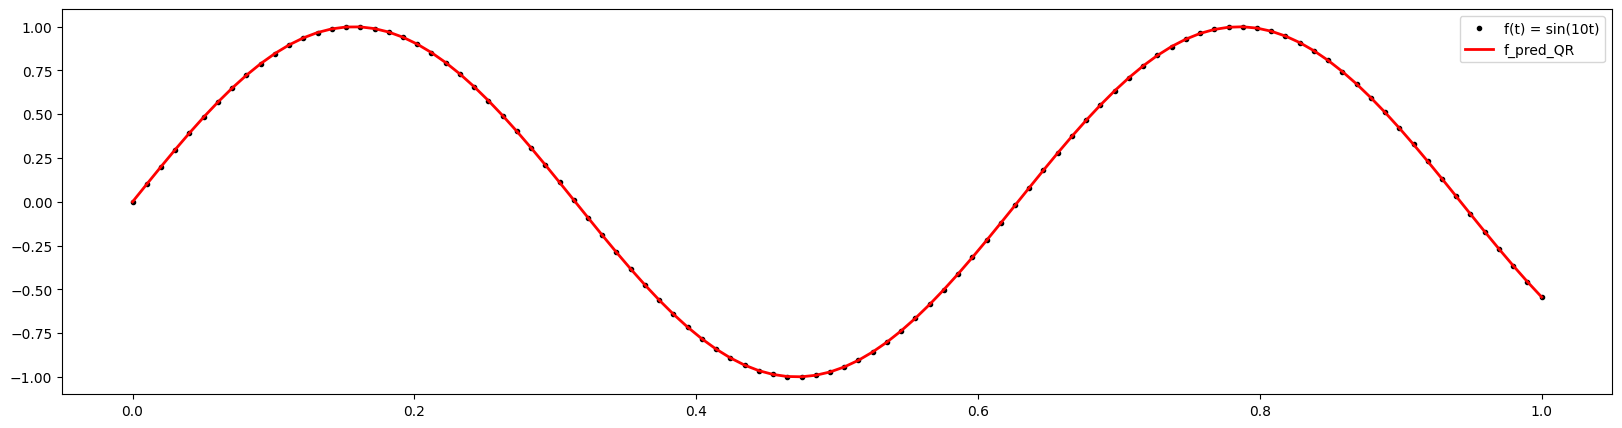

In [3]:
Q, R = MGS(A)
c_MGS = back_substitution(R, Q.T @ f)
c_MGS = np.reshape(c_MGS, (15,1))
f_pred_MGS = A@c_MGS

plt.figure(figsize=(20,5))
plt.plot(t,f, label='f(t) = sin(10t)', color='black', marker='o', markersize=3, linewidth=0)
plt.plot(t,f_pred_MGS, label='f_pred_QR', color = 'red', markersize = 0, linewidth =2)
plt.legend()


### b) QR using Householder Triangularization 

$$We\ use\ Householder\ to\ get\ R\ and\ Q^{T}f$$

$$Rc = Q^Tf$$

$$Then\ we\ can\ use\ back-subsitution\ to\ get\ c$$

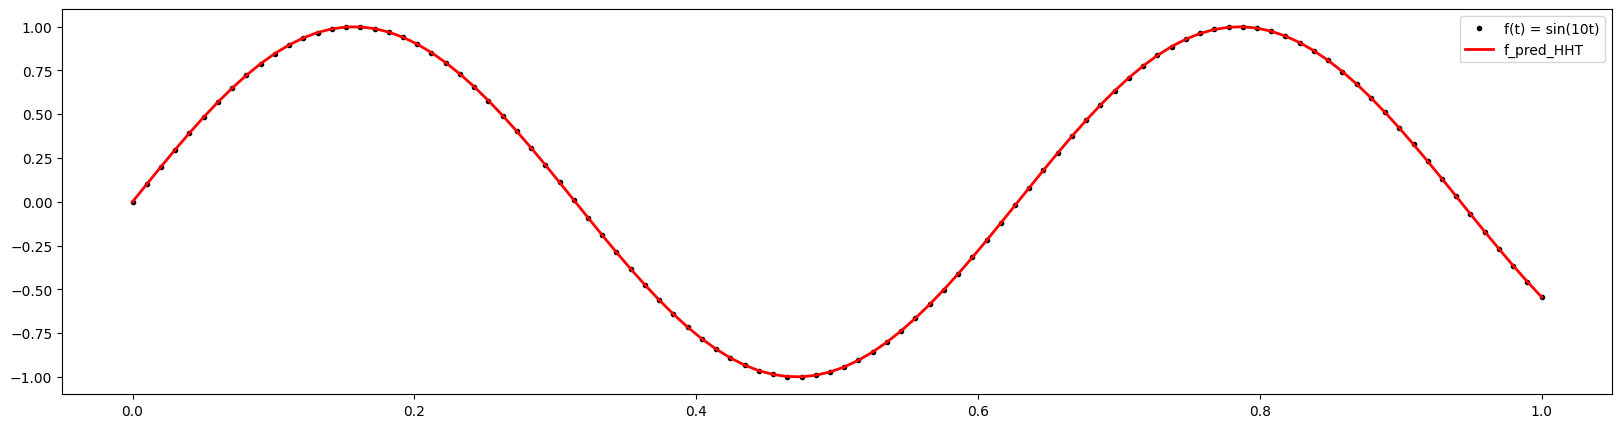

In [4]:
Qtf ,R = Householder(A,f)
c_HHT = back_substitution(R, Qtf)
f_pred_HHT = A @ c_HHT

plt.figure(figsize=(20,5))
plt.plot(t,f, label='f(t) = sin(10t)', color='black', marker='o', markersize=3, linewidth=0)
plt.plot(t,f_pred_HHT, label='f_pred_HHT', color = 'red', markersize = 0, linewidth =2)
plt.legend()

### c) Using SVD 

$$1) Compute\ SVD$$
$$2) Compute \ \hat{U^{T}}b$$
$$3) Solve\ for\ \tilde{w} \\ \hat{\Sigma} \tilde{w} = \hat{U^{T}} b$$
$$4) Solve\ for \ x \\ V^Tx = \tilde{w}

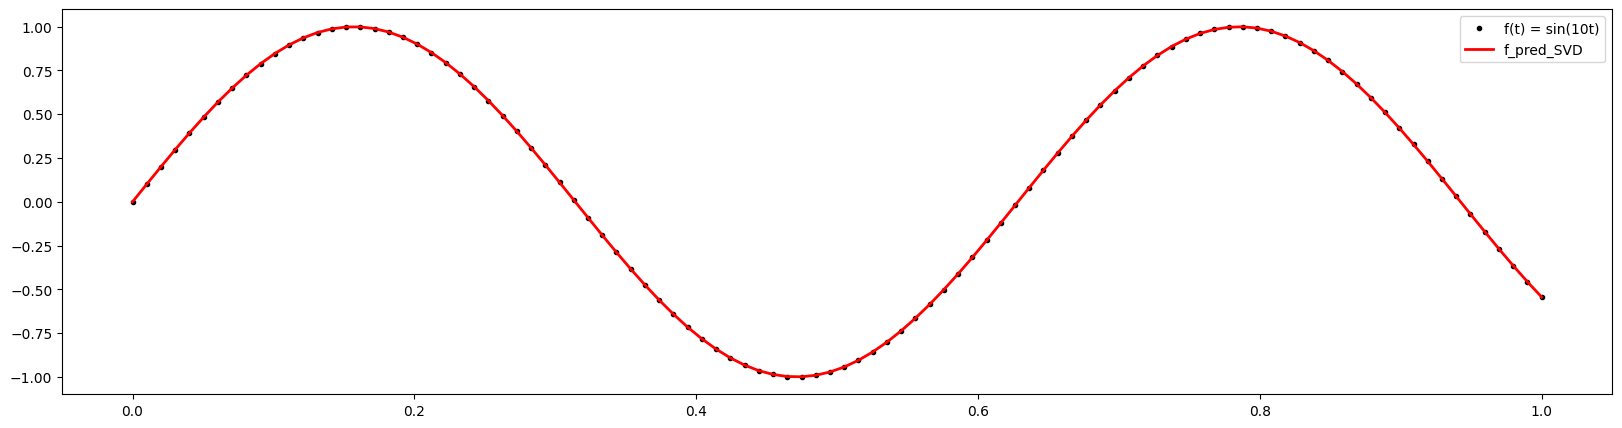

In [5]:
U, S, VT = np.linalg.svd(A, full_matrices= False)
UTb = U.T @ f
S = S*np.eye(S.shape[0])

w = back_substitution(S, UTb)
c_SVD = VT.T @ w

f_pred_SVD = A @ c_SVD

plt.figure(figsize=(20,5))
plt.plot(t,f, label='f(t) = sin(10t)', color='black', marker='o', markersize=3, linewidth=0)
plt.plot(t,f_pred_SVD, label='f_pred_SVD', color = 'red', markersize = 0, linewidth =2)
plt.legend()


### d) Using Normal equations \ command in matlab

$$ A^TAx = A^Tx$$
$$In\ matlab\ using\  \backslash \  command$$

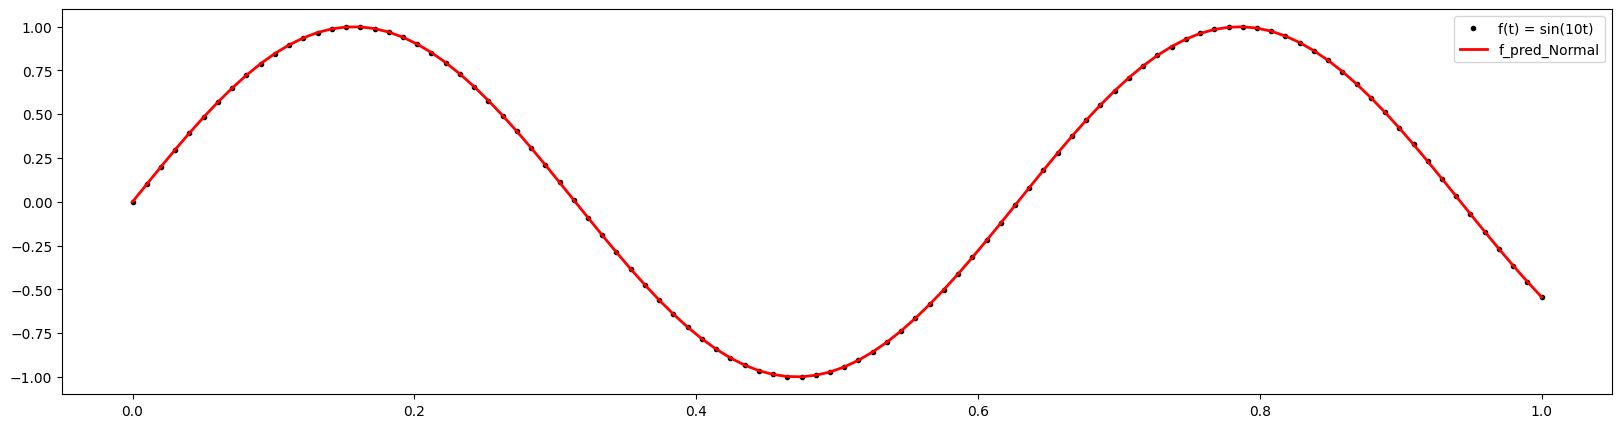

In [6]:
c_Normal = np.array(
        [
            0.00009748, 9.97359744, 1.22087079, -189.41596248, 221.14580470,
            -426.59920374, 4421.70131727, -11476.49362877, 10999.07736950, 1134.97183287,
            -14650.70543866, 19423.64843695, -14452.91862230, 6098.23877130, -1114.38934633
        ]
    )

f_pred_Normal = A @ c_Normal

plt.figure(figsize=(20,5))
plt.plot(t,f, label='f(t) = sin(10t)', color='black', marker='o', markersize=3, linewidth=0)
plt.plot(t,f_pred_Normal, label='f_pred_Normal', color = 'red', markersize = 0, linewidth =2)
plt.legend()


### True solution from Matlab

$$Ax = b$$
$$In\ matlab\ using\  \backslash \  command$$

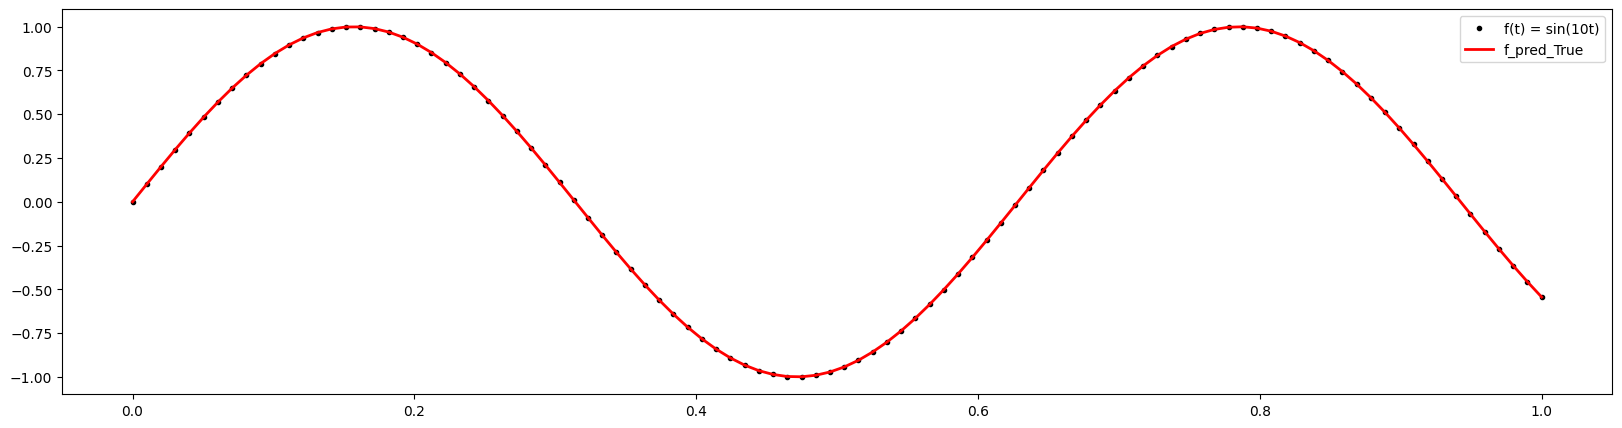

In [7]:
"""

"""

c_True = np.array(
    [
        -0.00000016, 10.00006007, -0.00314921, -166.61061960, -0.29594467,
        830.45651318, 55.22400378, -2392.04440709, 1801.11131016, -2508.83243359,
        10530.11024551, -16874.05799274, 12787.28761695, -4800.45028145, 727.56105819
    ]
)

f_pred_True = A @ c_True

plt.figure(figsize=(20,5))
plt.plot(t,f, label='f(t) = sin(10t)', color='black', marker='o', markersize=3, linewidth=0)
plt.plot(t,f_pred_True, label='f_pred_True', color = 'red', markersize = 0, linewidth =2)
plt.legend()


### We will now compare the solutions from all the methods on their least squares error 

In [8]:
def least_squares_error(y_true: np.array, y_pred: np.array) -> int:
    """
    Computes the least squares error (sum of squared errors) between the true and predicted values.
    """
    return np.dot(y_true - y_pred, y_true - y_pred)

f_pred_MGS = np.reshape(f_pred_MGS, (100,))

print(f"a) LSE for MGS = {least_squares_error(f_pred_True, f_pred_MGS)}")
print(f"b) LSE for HHT = {least_squares_error(f_pred_True, f_pred_HHT)}")
print(f"c) LSE for SVD = {least_squares_error(f_pred_True, f_pred_SVD)}")
print(f"d) LSE for Normal Equations = {least_squares_error(f_pred_True, f_pred_Normal)}")
print()
print(f"a) Coefficient of x^14 for MGS {c_MGS[-1]}")
print(f"b) Coefficient of x^14 for HHT {c_HHT[-1]}")
print(f"c) Coefficient of x^14 for SVD {c_SVD[-1]}")
print(f"d) Coefficient of x^14 for Normal Equations {c_Normal[-1]}")

print(f"True coefficient of x^14 for HHT {c_True[-1]}")


a) LSE for MGS = 9.402375692798181e-14
b) LSE for HHT = 1.1321338951663014e-15
c) LSE for SVD = 1.1317331635715833e-15
d) LSE for Normal Equations = 1.8213047820333308e-07

a) Coefficient of x^14 for MGS [721.56799766]
b) Coefficient of x^14 for HHT 727.5610626655764
c) Coefficient of x^14 for SVD 727.5610406830433
d) Coefficient of x^14 for Normal Equations -1114.38934633
True coefficient of x^14 for HHT 727.56105819


In [9]:
import pandas as pd
pd.options.display.float_format = '{:.8f}'.format

coefficients = pd.DataFrame(columns=['True', 'MGS', 'HHT', 'SVD', 'Normal Equations'], index=range(15))
coefficients['True'] = c_True
coefficients['MGS'] = c_MGS
coefficients['HHT'] = c_HHT
coefficients['SVD'] = c_SVD
coefficients['Normal Equations'] = c_Normal

coefficients

,True,MGS,HHT,SVD,Normal Equations
0,-0.00000016,-0.00000022,-0.00000016,-0.00000016,0.00009748
1,10.00006007,10.00008458,10.00006007,10.00006008,9.97359744
2,-0.00314921,-0.00461558,-0.00314922,-0.00314923,1.22087079
3,-166.61061960,-166.57538541,-166.61061941,-166.61061922,-189.41596248
4,-0.29594467,-0.74497248,-0.29594639,-0.29594853,221.14580470
5,830.45651318,833.92406381,830.45652285,830.45653810,-426.59920374
6,55.22400378,37.73386114,55.22396817,55.22389519,4421.70131727
7,-2392.04440709,-2331.80848490,-2392.04431955,-2392.04407680,-11476.49362877
8,1801.11131016,1655.90668355,1801.11116739,1801.11059622,10999.07736950
9,-2508.83243359,-2261.43698317,-2508.83228716,-2508.83133125,1134.97183287


In [91]:
np.set_printoptions(formatter={'float': '{:1.1e}'.format})
pd.options.display.float_format = '{:1.6e}'.format
b = f
x = c_HHT
A = A
y = A@x

A_plus = np.linalg.inv(A.T @ A) @ A.T

k_A = np.linalg.norm(A, 2) * np.linalg.norm(A_plus, 2)
eta = np.linalg.norm(A,2) * np.linalg.norm(x,2) / np.linalg.norm(y,2)
theta = np.arccos(np.linalg.norm(y,2) / np.linalg.norm(b,2))

matrix = {
    'y': [1 / np.cos(theta), k_A / np.cos(theta)],
    'x': [k_A / (eta * np.cos(theta)), k_A + (k_A ** 2) * np.tan(theta) / eta]
}

# Create a Pandas DataFrame with appropriate index and column names
condition_matrix = pd.DataFrame(matrix, index=['b', 'A'])

condition_matrix


,y,x
b,1.000000e+00,6.187516e+03
A,3.016178e+08,3.036732e+08


In [58]:
epsilon = np.finfo(float).eps
print(f"Machine epsilon: {epsilon}")

Machine epsilon: 2.220446049250313e-16
